In [1]:
from google.colab import drive
drive.mount('/gdrive')

# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, precision_score, recall_score
import os
import numpy as np
from PIL import Image

Mounted at /gdrive


# Load the Dataset

In [2]:
test_size = 0.2 # Sets the percentage of the test dataset to be loaded.

def load_images_and_masks(image_dir, mask_dir, test_size):
    # Get list of files and sort them to ensure alignment
    image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tif')])
    mask_files = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir) if file.endswith('.tif')])

    images = []
    masks = []

    # Print total counts
    print("Loading Images and Masks...")
    print(f"Total Images: {len(image_files)}")
    print(f"Total Masks: {len(mask_files)}")

    for idx, (image_file, mask_file) in enumerate(zip(image_files, mask_files), start=1):
        # Load image and mask
        image = Image.open(image_file)
        mask = Image.open(mask_file)

        # Convert to numpy array and append to lists
        images.append(np.array(image))
        masks.append(np.array(mask))

        # Print progress
        print(f"\rImage/Mask Pairs Processed: {idx}/{len(image_files)}", end='')

    return np.array(images), np.array(masks)

# Specify the paths to your image and mask directories
image_dir = '/gdrive/My Drive/Dataset/patches/test/images'
mask_dir = '/gdrive/My Drive/Dataset/patches/test/masks'

test_images, test_labels = load_images_and_masks(image_dir, mask_dir, test_size)
print(f'\nDataset Loaded...')
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Masks Shape: {test_labels.shape}")

Loading Images and Masks...
Total Images: 845
Total Masks: 845
Image/Mask Pairs Processed: 845/845
Dataset Loaded...
Test Images Shape: (845, 256, 256, 3)
Test Masks Shape: (845, 256, 256)


# Load the Model

In [3]:
from tensorflow.keras.backend import epsilon

def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon())

def jaccard_index(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    return (intersection + epsilon()) / (union + epsilon())

def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

In [4]:
# Replace 'model_path' with the actual path to your saved model
model_path = '/gdrive/My Drive/Dataset/Models/hrnet1.h5'
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient, 'jaccard_index': jaccard_index, 'sensitivity': sensitivity, 'specificity': specificity, 'precision': precision})
print('Model Loaded...')
print(f"Model Summary: \n{model.summary()}")

Model Loaded...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1728      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_no

# Evaluate & Visualize

In [5]:
# Make predictions
predictions = model.predict(test_images)

# Check the shape of the predictions, and if the last dimension is 1, squeeze it out
if predictions.ndim == 4 and predictions.shape[-1] == 1:
    predictions = np.squeeze(predictions, axis=-1)

27/27 [==============================] - 1345s 49s/step


In [6]:
# Apply the threshold to binarize the predictions
predictions_binary = (predictions > 0.3).astype(int) # CHANGE THE THRESHOLD HERE: 0.3, 0, 0.5 (default)

# Now check that test_labels has the same shape as predictions
# If test_labels have an extra dimension, squeeze that out as well
if test_labels.ndim == 4 and test_labels.shape[-1] == 1:
    test_labels = np.squeeze(test_labels, axis=-1)

# Ensure that test_labels is a binary mask as well
test_labels = (test_labels > 0.5).astype(int)

IoU for the building class: 0.017295219793418207
IoU Score: 0.4562111283605256
Dice Score: 0.48933206900838766
Precision: 0.4889309115044961
Recall: 0.4941969758286515


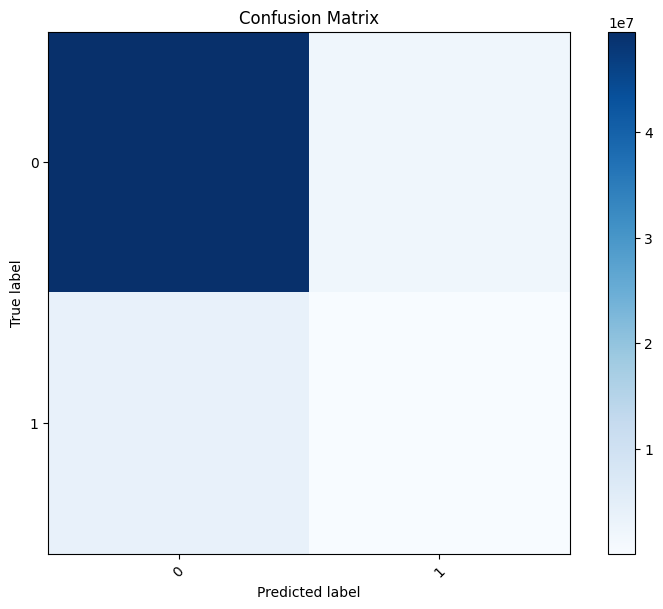

              precision    recall  f1-score   support

           0       0.93      0.96      0.94  51390170
           1       0.05      0.03      0.03   3987750

    accuracy                           0.90  55377920
   macro avg       0.49      0.49      0.49  55377920
weighted avg       0.86      0.90      0.88  55377920



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics import (jaccard_score, f1_score, precision_score, recall_score,
                             confusion_matrix, classification_report)

# Function to calculate IoU for the building class
def calculate_iou(true_masks, pred_masks, pos_label=1):
    intersection = np.logical_and(true_masks == pos_label, pred_masks == pos_label).sum()
    union = np.logical_or(true_masks == pos_label, pred_masks == pos_label).sum()
    iou = intersection / union if union != 0 else 0
    return iou

# Calculate metrics
iou_building_class = calculate_iou(test_labels, predictions_binary)
iou_score = jaccard_score(test_labels.flatten(), predictions_binary.flatten(), average='macro')
dice_score = f1_score(test_labels.flatten(), predictions_binary.flatten(), average='macro')
precision = precision_score(test_labels.flatten(), predictions_binary.flatten(), average='macro', zero_division=1)
recall = recall_score(test_labels.flatten(), predictions_binary.flatten(), average='macro', zero_division=1)

# Print metrics
print(f"IoU for the building class: {iou_building_class}")
print(f"IoU Score: {iou_score}")
print(f"Dice Score: {dice_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create and plot a standard confusion matrix
conf_matrix = confusion_matrix(test_labels.flatten(), predictions_binary.flatten())
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0, 1], rotation=45)
plt.yticks(tick_marks, [0, 1])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report
print(classification_report(test_labels.flatten(), predictions_binary.flatten(), zero_division=1))

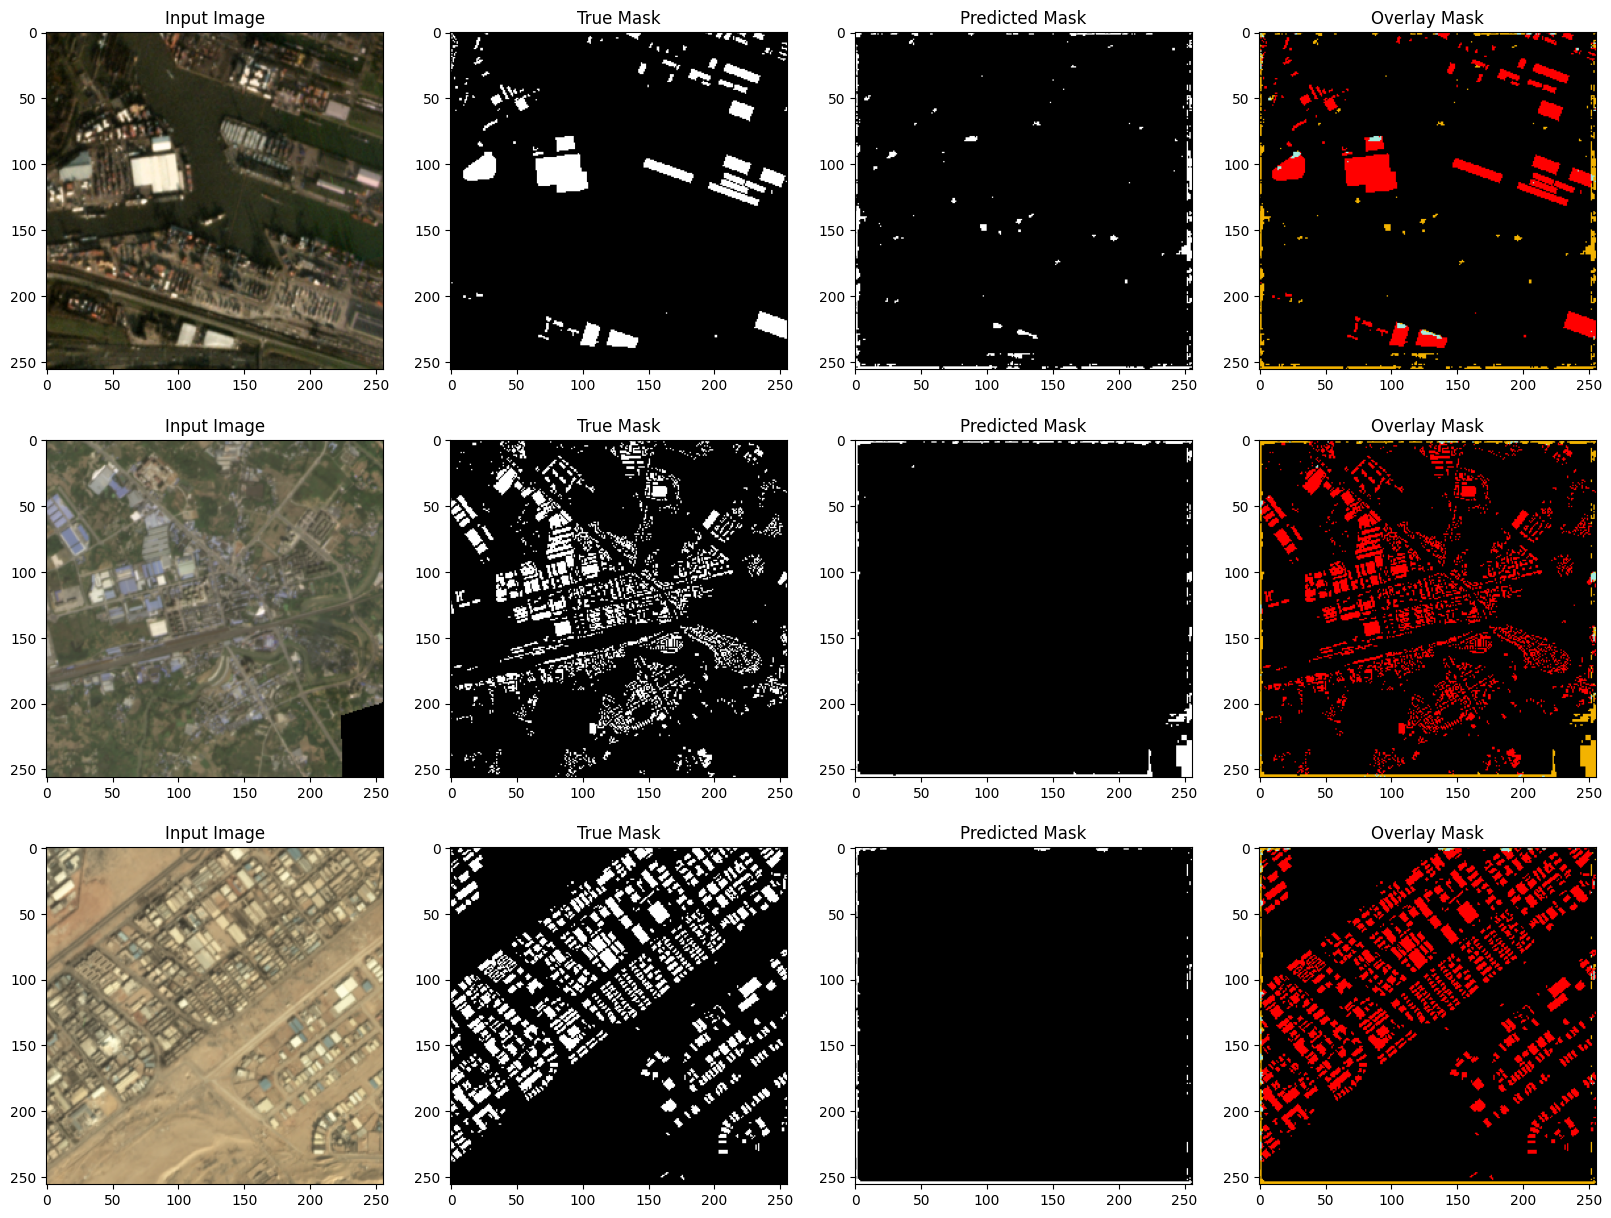

In [10]:
# Randomly select some examples to plot
indices = np.random.choice(range(len(test_images)), 3, replace=False)
sample_images = test_images[indices]
sample_true_masks = test_labels[indices]
sample_pred_masks = predictions_binary[indices]

def plot_examples_with_overlay(images, true_masks, pred_masks, num_examples=3):
    fig, axs = plt.subplots(num_examples, 4, figsize=(20, 5*num_examples))  # Increase the number of columns to 4
    for i in range(num_examples):
        axs[i, 0].imshow(images[i])
        axs[i, 0].title.set_text('Input Image')

        axs[i, 1].imshow(true_masks[i], cmap='gray')
        axs[i, 1].title.set_text('True Mask')

        axs[i, 2].imshow(pred_masks[i], cmap='gray')
        axs[i, 2].title.set_text('Predicted Mask')

        # Create an overlay image
        overlay = np.zeros((*true_masks[i].shape, 3), dtype=np.uint8)
        # True Negatives (remain black)
        # True Positives to Blue
        overlay[(true_masks[i] == 1) & (pred_masks[i] == 1)] = [164, 236, 222] #80, 157, 194 # 164, 236, 222
        # False Positives to Red
        overlay[(true_masks[i] == 0) & (pred_masks[i] == 1)] = [243, 179, 0]
        # False Negatives to Orange
        overlay[(true_masks[i] == 1) & (pred_masks[i] == 0)] = [255, 0, 0]

        axs[i, 3].imshow(overlay)
        axs[i, 3].title.set_text('Overlay Mask')

    plt.show()

# Then call this new function with your sample data
plot_examples_with_overlay(sample_images, sample_true_masks, sample_pred_masks)
